In [1]:
import tensorflow.compat.v2 as tf

In [3]:
!pip install tensorflow_datasets

     ---------------------------------------- 4.2/4.2 MB 7.2 MB/s eta 0:00:00
  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 48.8/48.8 KB 145.1 kB/s eta 0:00:00
     -------------------------------------- 241.5/241.5 KB 3.7 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21502 sha256=b0d8bfe4a3c643eaaa251f15d23efce2edf726b58834ef7b4ee8c12894e54bf2
  Stored in directory: c:\users\nitropc\appdata\local\pip\cache\wheels\e1\e8\83\ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built promise


In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt


import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [11]:
from tensorflow_datasets.image_classification import CaltechBirds2011

dataset_all, info = CaltechBirds2011.load(with_info=True)

ImportError: cannot import name 'CaltechBirds2011' from 'tensorflow_datasets.image_classification' (C:\Users\NitroPC\anaconda3\lib\site-packages\tensorflow_datasets\image_classification\__init__.py)

Пробовал взять датасет калтеховских птичек, но его куда-то убрали. У других датасетов нет масок сегментации.

In [17]:
#ds_names = ( 'caltech_birds2011',)
ds_names = ( 'oxford_iiit_pet:3.*.*',)
dataset_all, info = tfds.load(ds_names[0], split = ['train[:10%]','test[-10%:]'], with_info=True)

In [18]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\NitroPC\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
 

In [19]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [20]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [21]:
@tf.function
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [60]:
OUTPUT_CHANNELS = 3

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGTH // 10 // BATCH_SIZE

In [61]:
train = dataset_all[0].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset_all[1].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [62]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

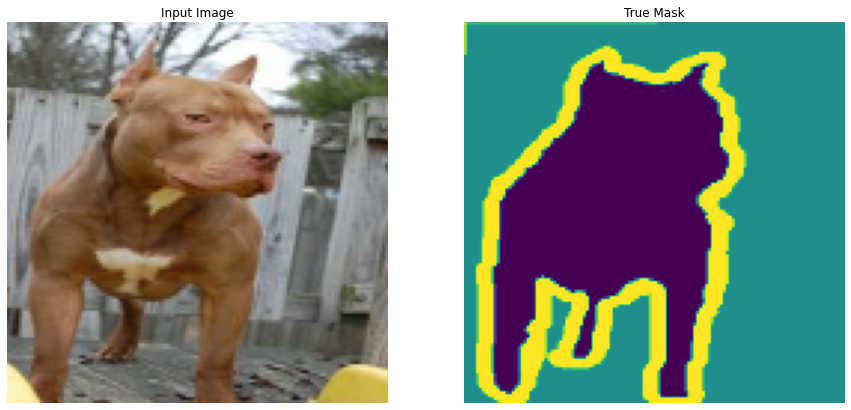

In [63]:
for image, mask in test_dataset.take(5):
  sample_image, sample_mask = image, mask
display([sample_image[1,:,:,:], sample_mask[1,:,:,:]])

In [64]:
sample_mask.numpy().min(),sample_mask.numpy().max()

(0.0, 2.0)

In [65]:
sample_mask.dtype

tf.float32

In [66]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [67]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [68]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [69]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      print(1)
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image[0,:,:,:], sample_mask[0,:,:,:],
             create_mask(model.predict(sample_image[:,:,:]))])

1/1 [==============================] - 1s 869ms/step


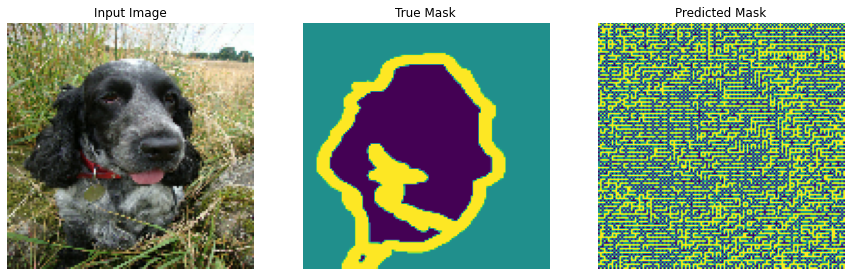

In [70]:
show_predictions()

In [71]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 374ms/step


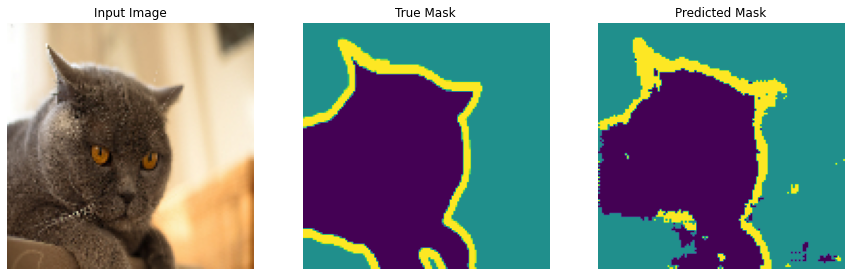


Sample Prediction after epoch 10

11/11 [==============================] - 9s 785ms/step - loss: 0.1859 - accuracy: 0.9202 - val_loss: 0.3522 - val_accuracy: 0.8598


In [59]:
EPOCHS = 5 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//10//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

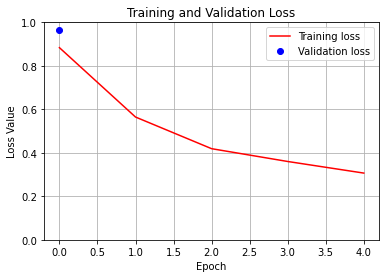

In [58]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.grid('on')
plt.legend()
plt.show()

Base (5 epochs, batch size = 16): loss: 0.2867 - accuracy: 0.8834 - val_loss: 0.3798 - val_accuracy: 0.8537

Variant 1 (15 epochs, batch size = 16): loss: 0.1562 - accuracy: 0.9315 - val_loss: 0.3937 - val_accuracy: 0.8557

Variant 2 (5 epochs, batch size = 32): loss: 0.3068 - accuracy: 0.8784 - val_loss: 1.1972 - val_accuracy: 0.6471

Variant 3 (15 epochs, batch size = 32): loss: 0.1859 - accuracy: 0.9202 - val_loss: 0.3522 - val_accuracy: 0.8598

Вывод: Увеличение числа эпох увеличивает точность. Увеличение размера батча уменьшает переобучение.